In [1]:
%matplotlib inline

# YOLO/PASCAL-VOC detection example

This example demonstrates Akida's object detection capabilities using the YOLOv2 architecture.

The notebook below is derived from the ["YOLO/PASCAL-VOC detection tutorial"](https://doc.brainchipinc.com/examples/general/plot_5_voc_yolo_detection.html) tutorial on the Brainchip Developer MetaTF website.

### 1. Import model

The model used for this demonstration can be found at the [Akida 2.0 Model Zoo](https://doc.brainchipinc.com/model_zoo_performance.html#id4). It has been pre-downloaded and converted to Akida here for efficiency.

In [2]:
from akida import Model

model_akida = Model("models/yolo_akidanet_voc_i8_w8_a8.fbz")
model_akida.summary()

                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[224, 224, 3]  [7, 7, 125]   1          33    
________________________________________________

__________________________________________________________________________
Layer (type)                          Output shape    Kernel shape      

==================== SW/conv_0-dequantizer (Software) ====================

conv_0 (InputConv2D)                  [112, 112, 16]  (3, 3, 3, 16)     
__________________________________________________________________________
conv_1 (Conv2D)                       [112, 112, 32]  (3, 3, 16, 32)    
__________________________________________________________________________
conv_2 (Conv2D)                       [56, 56, 64]    (3, 3, 32, 64)    
__________________________________________________________________________
conv_3 (Conv2D)                       [56, 56, 64]    (3, 3, 64, 64)    
________________

### 2. Map the model onto the FPGA

For more details on this flow, please see: [Model Hardware Mapping](https://doc.brainchipinc.com/user_guide/akida.html#model-hardware-mapping)

In [3]:
import akida
from cnn2snn import set_akida_version, AkidaVersion
# Instantiate akida model
with set_akida_version(AkidaVersion.v2):
    devices = akida.devices()
    if len(devices) > 0:
        print(f'Available devices: {[dev.desc for dev in devices]}')
        device = devices[0]
        print(device.version)
        try:
            model_akida.map(device)
            print(f"Mapping to Akida device {device.desc}.")
        except Exception as e:
            print("Model not compatible with FPGA. Running on CPU.")
    else:
        print("No Akida devices found, running on CPU.")


2025-07-24 12:35:59.269610: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-24 12:35:59.674090: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-24 12:35:59.674325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-24 12:35:59.746105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-24 12:35:59.899030: I tensorflow/core/platform/cpu_feature_guar

No Akida devices found, running on CPU.


/home/kmanninen/miniconda3/envs/akida_env/lib/python3.11/site-packages/onnxscript/converter.py:816: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


### 3 Load the sample image data

Similar to the model, the sample image data and associated anchors have been pre-downloaded for efficiency. You can learn more about the YOLO data that is available by referencing the [Developer MetaTF API Reference](https://doc.brainchipinc.com/api_reference/akida_models_apis.html#yolo). 

In [4]:
import tensorflow as tf
import pickle

# Helper function to load and parse the Tfrecord file.
def load_tf_dataset(tf_record_file_path):
    tfrecord_files = [tf_record_file_path]

    # Feature description for parsing the TFRecord
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'objects/bbox': tf.io.VarLenFeature(tf.float32),
        'objects/label': tf.io.VarLenFeature(tf.int64),
    }

    def _count_tfrecord_examples(dataset):
        return len(list(dataset.as_numpy_iterator()))

    def _parse_tfrecord_fn(example_proto):
        example = tf.io.parse_single_example(example_proto, feature_description)

        # Decode the image from bytes
        example['image'] = tf.io.decode_jpeg(example['image'], channels=3)

        # Convert the VarLenFeature to a dense tensor
        example['objects/label'] = tf.sparse.to_dense(example['objects/label'], default_value=0)

        example['objects/bbox'] = tf.sparse.to_dense(example['objects/bbox'])
        # Boxes were flattenned that's why we need to reshape them
        example['objects/bbox'] = tf.reshape(example['objects/bbox'],
                                             (tf.shape(example['objects/label'])[0], 4))
        # Create a new dictionary structure
        objects = {
            'label': example['objects/label'],
            'bbox': example['objects/bbox'],
        }

        # Remove unnecessary keys
        example.pop('objects/label')
        example.pop('objects/bbox')

        # Add 'objects' key to the main dictionary
        example['objects'] = objects

        return example

    # Create a TFRecordDataset
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    len_dataset = _count_tfrecord_examples(dataset)
    parsed_dataset = dataset.map(_parse_tfrecord_fn)

    return parsed_dataset, len_dataset


labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
          'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
          'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
          'train', 'tvmonitor']

val_dataset, len_val_dataset = load_tf_dataset("datasets/test_20_classes.tfrecord")
print(f"Loaded VOC2007 sample test data: {len_val_dataset} images.")

with open("datasets/coco_anchors.pkl", 'rb') as handle:
        anchors = pickle.load(handle)
print(f"Loaded anchors")

Loaded VOC2007 sample test data: 100 images.
Loaded anchors


### 4 Run inference on a random image

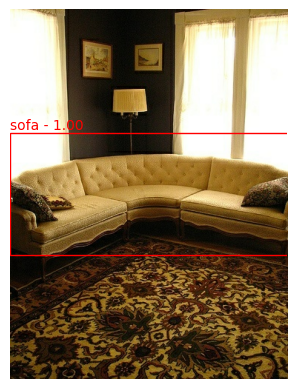

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from akida_models.detection.processing import preprocess_image, decode_output

# Shuffle the data to take a random test image
val_dataset = val_dataset.shuffle(buffer_size=len_val_dataset)

input_shape = model_akida.layers[0].input_dims

# Load the image
raw_image = next(iter(val_dataset))['image']

# Keep the original image size for later bounding boxes rescaling
raw_height, raw_width, _ = raw_image.shape

# Pre-process the image
image = preprocess_image(raw_image, input_shape)
input_image = image[np.newaxis, :].astype(np.uint8)

# Call evaluate on the image
pots = model_akida.predict(input_image)[0]

# Reshape the potentials to prepare for decoding
h, w, c = pots.shape
pots = pots.reshape((h, w, len(anchors), 4 + 1 + len(labels)))

# Decode potentials into bounding boxes
raw_boxes = decode_output(pots, anchors, len(labels))

# Rescale boxes to the original image size
pred_boxes = np.array([[
    box.x1 * raw_width, box.y1 * raw_height, box.x2 * raw_width,
    box.y2 * raw_height,
    box.get_label(),
    box.get_score()
] for box in raw_boxes])

fig = plt.figure(num='VOC detection by Akida')
ax = fig.subplots(1)
img_plot = ax.imshow(np.zeros(raw_image.shape, dtype=np.uint8))
img_plot.set_data(raw_image)

for box in pred_boxes:
    rect = patches.Rectangle((box[0], box[1]),
                             box[2] - box[0],
                             box[3] - box[1],
                             linewidth=1,
                             edgecolor='r',
                             facecolor='none')
    ax.add_patch(rect)
    class_score = ax.text(box[0],
                          box[1] - 5,
                          f"{labels[int(box[4])]} - {box[5]:.2f}",
                          color='red')

plt.axis('off')
plt.show()